<a href="https://colab.research.google.com/github/helya02/Diffusion-Model/blob/main/Diffusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50, Loss: 0.1701
Epoch 2/50, Loss: 0.0875
Epoch 3/50, Loss: 0.0732
Epoch 4/50, Loss: 0.0676
Epoch 5/50, Loss: 0.0655
Epoch 6/50, Loss: 0.0627
Epoch 7/50, Loss: 0.0605
Epoch 8/50, Loss: 0.0591
Epoch 9/50, Loss: 0.0583
Epoch 10/50, Loss: 0.0573
Epoch 11/50, Loss: 0.0558
Epoch 12/50, Loss: 0.0560
Epoch 13/50, Loss: 0.0546
Epoch 14/50, Loss: 0.0540
Epoch 15/50, Loss: 0.0539
Epoch 16/50, Loss: 0.0538
Epoch 17/50, Loss: 0.0532
Epoch 18/50, Loss: 0.0533
Epoch 19/50, Loss: 0.0526
Epoch 20/50, Loss: 0.0538
Epoch 21/50, Loss: 0.0524
Epoch 22/50, Loss: 0.0525
Epoch 23/50, Loss: 0.0518
Epoch 24/50, Loss: 0.0518
Epoch 25/50, Loss: 0.0512
Epoch 26/50, Loss: 0.0514
Epoch 27/50, Loss: 0.0510
Epoch 28/50, Loss: 0.0520
Epoch 29/50, Loss: 0.0512
Epoch 30/50, Loss: 0.0501
Epoch 31/50, Loss: 0.0511
Epoch 32/50, Loss: 0.0500
Epoch 33/50, Loss: 0.0502
Epoch 34/50, Loss: 0.0501
Epoch 35/50, Loss: 0.0497
Epoch 36/50, Loss: 0.0499
Epoch 37/50, Loss: 0.0491
Epoch 38/50, Loss: 0.0504
Epoch 39/50, Loss: 0.

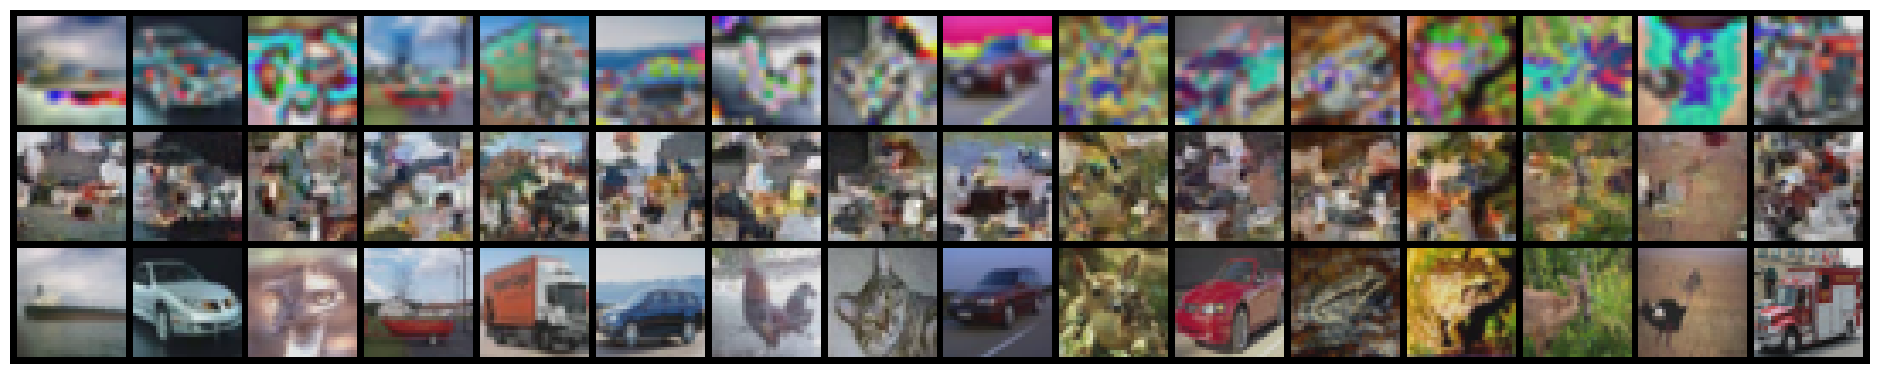

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


T = 400  # number of diffusion steps
beta = torch.linspace(1e-4, 0.02, T)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'



device = 'cuda' if torch.cuda.is_available() else 'cpu'
beta = torch.linspace(1e-4, 0.02, T).to(device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0).to(device)


def get_time_channel(t, shape):
    # t is a tensor of shape (batch,)
    # Normalize t to [0,1] and expand spatially.
    t_norm = (t.float() / T).view(-1, 1, 1, 1)
    return t_norm.expand(-1, shape[1], shape[2], shape[3])


def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    # Index alpha_bar at time t for each sample and reshape for broadcasting.
    sqrt_alpha_bar = torch.sqrt(alpha_bar[t]).view(-1, 1, 1, 1).to(x0.device)
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar[t]).view(-1, 1, 1, 1).to(x0.device)
    return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise


class CIFAR10_SR(CIFAR10):
    def __init__(self, root, train=True, transform=None, download=False, low_res_size=16):
        super().__init__(root=root, train=train, transform=transform, download=download)
        self.low_res_size = low_res_size
        self.low_res_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((low_res_size, low_res_size), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize((32, 32), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x * 2 - 1)  # scale [0,1] -> [-1,1]
        ])

    def __getitem__(self, index):
        # High-res image using the given transform
        img, label = super().__getitem__(index)
        # Create low-res version
        low_res_img = self.low_res_transform(img)
        return img, low_res_img


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])

# Load CIFAR-10 training dataset
train_dataset = CIFAR10_SR(root='./data', train=True, transform=transform, download=True, low_res_size=16)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)


class ConditionalDiffusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(9, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x, low_res, t):
        # Create a time channel from t
        t_channel = get_time_channel(t, x.shape)
        # Concatenate along channels: [x (3), low_res (3), t_channel (1)] → (7 channels)
        x_in = torch.cat([x, low_res, t_channel], dim=1)
        h = self.relu(self.conv1(x_in))
        h = self.relu(self.conv2(h))
        h = self.relu(self.conv3(h))
        out = self.conv4(h)
        return out

model = ConditionalDiffusionModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (high_res, low_res) in enumerate(train_loader):
        high_res = high_res.to(device)  # Ground truth image
        low_res = low_res.to(device)    # Condition: blurry low-res image
        batch_size = high_res.size(0)
        # Sample random timesteps for each image
        t = torch.randint(0, T, (batch_size,), device=device)
        noise = torch.randn_like(high_res)
        x_noisy = q_sample(high_res, t, noise)
        # Model predicts the noise added
        noise_pred = model(x_noisy, low_res, t)
        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


@torch.no_grad()
def sample_super_resolution(model, low_res, steps=T):
    # low_res: conditioned low-res image [B, 3, 32, 32]
    model.eval()
    batch_size = low_res.size(0)
    # Start from pure Gaussian noise
    x = torch.randn(batch_size, 3, 32, 32).to(device)
    for t in reversed(range(steps)):
        t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)
        pred_noise = model(x, low_res, t_tensor)
        alpha_t = alpha[t]
        alpha_bar_t = alpha_bar[t]
        beta_t = beta[t]
        # Reverse diffusion update
        x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * pred_noise)
        if t > 0:
            noise = torch.randn_like(x)
            x = x + torch.sqrt(beta_t) * noise
    return x

test_dataset = CIFAR10_SR(root='./data', train=False, transform=transform, download=True, low_res_size=16)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
high_res_test, low_res_test = next(iter(test_loader))
high_res_test = high_res_test.to(device)
low_res_test = low_res_test.to(device)


samples = sample_super_resolution(model, low_res_test)

# - Top row: low-res (condition)
# - Middle row: model output (super-resolved)
# - Bottom row: ground truth high-res
grid = torchvision.utils.make_grid(torch.cat([low_res_test, samples, high_res_test], dim=0), nrow=16, normalize=True)
plt.figure(figsize=(24, 12))
plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

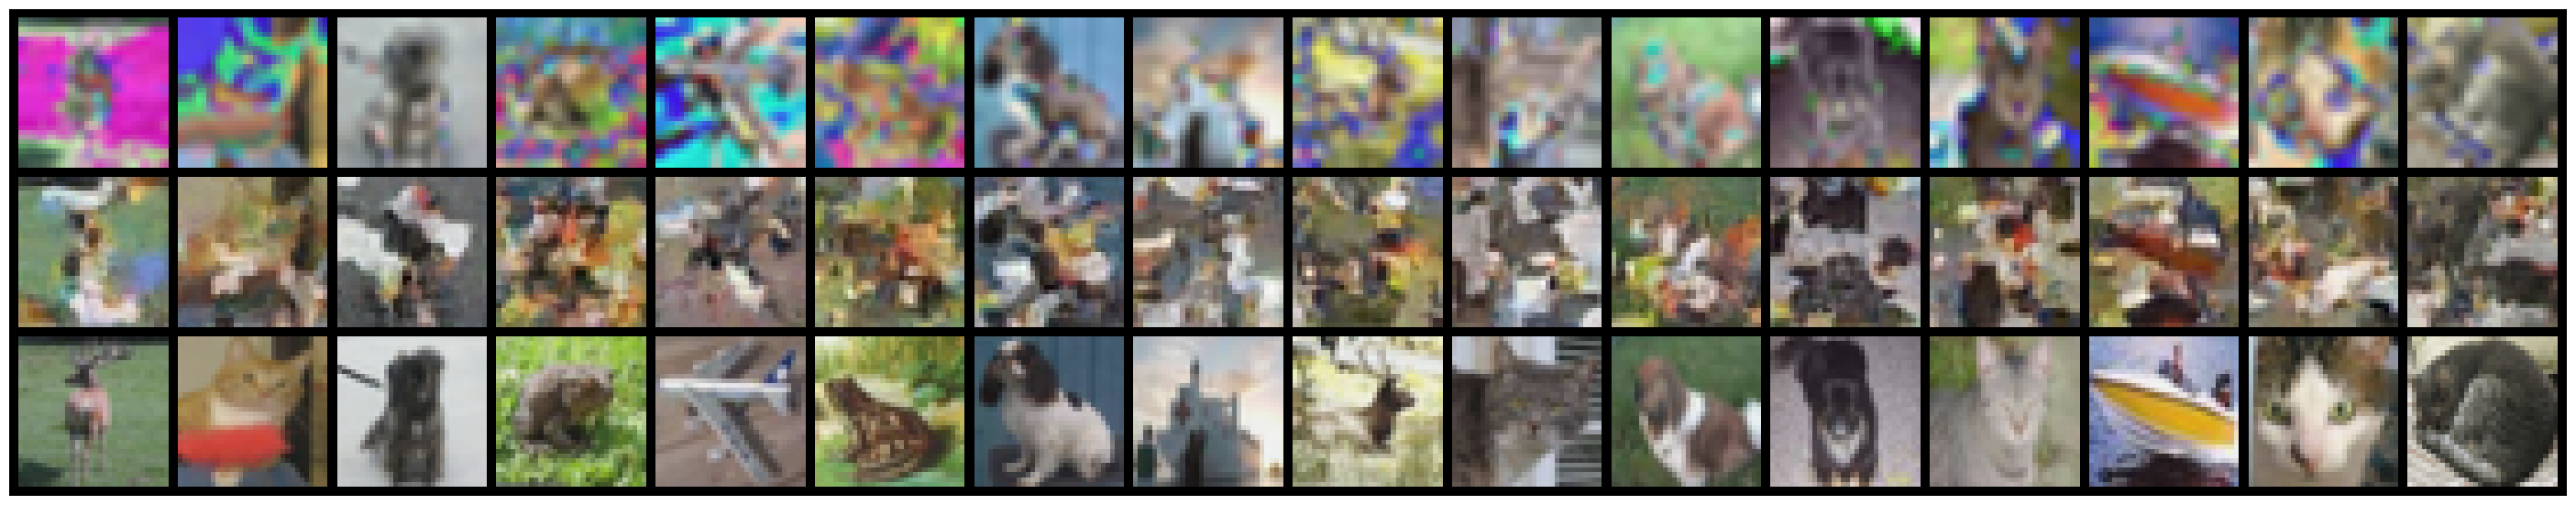

In [5]:
# ---------------------------
# Visualize Results
# ---------------------------
# Load test dataset
test_dataset = CIFAR10_SR(root='./data', train=False, transform=transform, download=True, low_res_size=16)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
high_res_test, low_res_test = next(iter(test_loader))
high_res_test = high_res_test.to(device)
low_res_test = low_res_test.to(device)

# Generate super-resolved samples
samples = sample_super_resolution(model, low_res_test)

# Create a grid to display:
# - Top row: low-res (condition)
# - Middle row: model output (super-resolved)
# - Bottom row: ground truth high-res
grid = torchvision.utils.make_grid(torch.cat([low_res_test, samples, high_res_test], dim=0), nrow=16, normalize=True)
plt.figure(figsize=(36, 12))
plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()